In [1]:
#import logging
#logging.getLogger().setLevel(logging.ERROR)

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.utils.data
import itertools
from torch.utils.data import Dataset
import torchani
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.utils import scatter
#from rdkit import RDLogger
#lg = RDLogger.logger()
#lg.setLevel(RDLogger.ERROR)
#RDLogger.logger().setLevel(RDLogger.CRITICAL)

#from rdkit import Chem
#from rdkit.Chem import AllChem
#from rdkit.Chem import Draw
#from rdkit.Chem.Draw import IPythonConsole
#from rdkit.Chem import rdDepictor
#from rdkit.Chem.rdmolops import GetAdjacencyMatrix

from torch_geometric.utils.convert import from_scipy_sparse_matrix

#IPythonConsole.ipython_useSVG = True  # Enable SVG rendering
#rdDepictor.SetPreferCoordGen(True)  # Ensure molecule coordinates are generated

#from xyz2mol import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


In [3]:
def load_ani_dataset(dspath):

    
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']
    
    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("/global/scratch/users/timp/datasets/ani_gdb_s01_to_s04.h5")
print(dataset)
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)

In [4]:
def make_dataloader(dataset, batch_size=8192, shuffle=True):
    
    filtered_data = list(filter(lambda x: x is not None, dataset))
    dataloader = GraphDataLoader(filtered_data, batch_size=batch_size, shuffle=shuffle)

    return dataloader

def move_data_to_device(dataloader, device):
    for data in dataloader.dataset:
        data = data.to(device)
        data.y = torch.tensor(data.y).to(device)

In [ ]:
node_hidden_dim = 128
edge_hidden_dim = 128

net = GraphNet(node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim).to(device)

In [ ]:
# train 
learning_rate = 1e-3
n_epoch = 50
batch_size = 2048
l2 = 1e-4

trainer = GNNTrainer(net, batch_size, learning_rate, n_epoch, l2)
trainer.train(graph_ani_train_loader, graph_ani_val_loader)

In [12]:
node_input_dim = graph_train.dataset[0].x.shape[1]
edge_input_dim = graph_train.dataset[0].edge_attr.shape[1]

In [15]:
node_hidden_dim = 128
edge_hidden_dim = 128

net = GraphNet(node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim).to(device)

In [15]:
graph_train_list = [graph_train_1, graph_train_2, graph_train_3, graph_train_4]

In [16]:
def check_dataloader_device(dataloader):
    loop = 0
    for batch_data in dataloader:
        # Print the device of each tensor in the batch
        print("Node features device:", batch_data.x.device)
        print("Edge features device:", batch_data.edge_attr.device)
        print("Edge index device:", batch_data.edge_index.device)
        print("Target tensor device:", batch_data.y.device)
        loop += 1
        if loop >= 3:
            return 

check_dataloader_device(graph_train)

Node features device: cuda:0
Edge features device: cuda:0
Edge index device: cuda:0
Target tensor device: cuda:0
Node features device: cuda:0
Edge features device: cuda:0
Edge index device: cuda:0
Target tensor device: cuda:0
Node features device: cuda:0
Edge features device: cuda:0
Edge index device: cuda:0
Target tensor device: cuda:0


GraphNet - Number of parameters: 84609


100%|██████████| 50/50 [1:01:12<00:00, 73.45s/it] 


[array(0.0029157, dtype=float32),
 array(0.00384375, dtype=float32),
 array(0.00260933, dtype=float32),
 array(0.00277813, dtype=float32),
 array(0.00259892, dtype=float32),
 array(0.00237202, dtype=float32),
 array(0.00231348, dtype=float32),
 array(0.00252627, dtype=float32),
 array(0.00249178, dtype=float32),
 array(0.0022276, dtype=float32),
 array(0.00230725, dtype=float32),
 array(0.00250707, dtype=float32),
 array(0.00244033, dtype=float32),
 array(0.00233226, dtype=float32),
 array(0.00229282, dtype=float32),
 array(0.0022483, dtype=float32),
 array(0.00219979, dtype=float32),
 array(0.00250606, dtype=float32),
 array(0.0022709, dtype=float32),
 array(0.00230809, dtype=float32),
 array(0.00240601, dtype=float32),
 array(0.00225652, dtype=float32),
 array(0.00223784, dtype=float32),
 array(0.00230702, dtype=float32),
 array(0.0023187, dtype=float32),
 array(0.00229485, dtype=float32),
 array(0.00239114, dtype=float32),
 array(0.00236081, dtype=float32),
 array(0.0022558, dtype=f

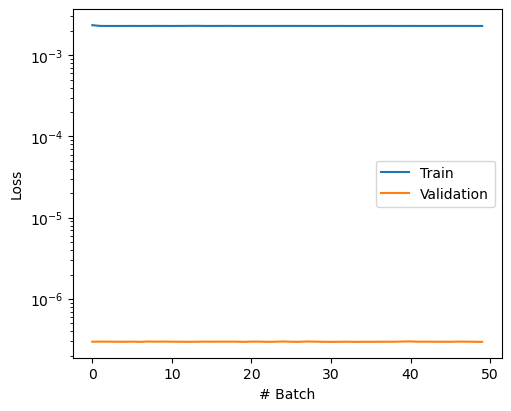

In [28]:
# train 
learning_rate = 1e-3
n_epoch = 50
batch_size = 16384
l2 = 1e-4

trainer = GNNTrainer(net, batch_size, learning_rate, n_epoch, l2)
trainer.train(graph_train, graph_val)

2.88085686718791e-07

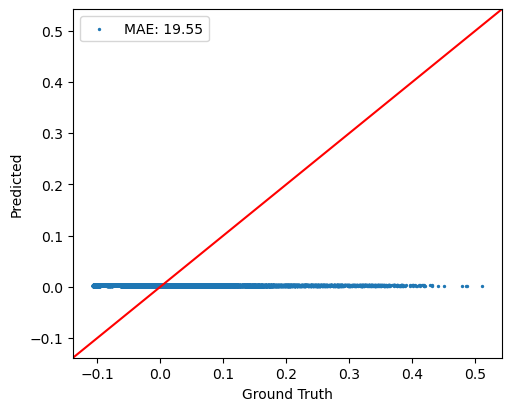

In [29]:
trainer.evaluate(graph_test)
#trainer.evaluate(dev_graph_train)

In [9]:
class ANITrainer:
    def __init__(self, model, batch_size, epoch, opt_method="adam", loss_func=nn.MSELoss(), learning_rate=1e-3, l2=1e-9):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        if opt_method == "sgdm":
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        elif opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        self.epoch = epoch
        self.batch_size = batch_size
        #Generally MSE is better than cross-entropy for regression, so it is the default
        
        self.loss = loss_func
        self.batch_size = batch_size
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(batch_size).cache()
        #val_data_loader = val_data.collate(batch_size).cache()
        
        # definition of loss function: MSE is a good choice! 
        loss_func = self.loss
        
        # record epoch losses
        train_loss_list, val_loss_list, lowest_val_loss = [], [], np.inf

        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                #print("computing energies...")
                # compute energies
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                _, pred_energies = self.model((species, coords))
                
                # compute loss
                batch_loss = loss_func(true_energies, pred_energies)
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = pred_energies.shape[0]/len(train_data)
                train_epoch_loss += batch_loss.detach().to(device).item() * batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            val_epoch_loss = self.evaluate(val_data, draw_plot=False)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)

            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            x_axis = np.arange(self.epoch)
            # Plot train loss and validation loss
            ax.plot(x_axis, train_loss_list, label='Train')
            ax.plot(x_axis, val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        self.model.eval()
        #print("evaluate has been called")
        # init data loader
        data_loader = data.collate(batch_size).cache()
        
        # init loss function
        loss_func = self.loss
        total_loss = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                
                # compute energies
                species = batch_data['species'].to(device)
                coords = batch_data['coordinates'].to(device)
                true_energies = batch_data['energies'].to(device).float()
                _, pred_energies = self.model((species, coords))
                
                # compute loss
                batch_loss = loss_func(pred_energies, true_energies)

                batch_importance = pred_energies.shape[0] / len(data)
                total_loss += batch_loss.detach().to(device).item() * batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss
        

In [7]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
atomic_model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

In [48]:
class wideAtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = wideAtomicNet()
net_C = wideAtomicNet()
net_N = wideAtomicNet()
net_O = wideAtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
wide_ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
wide_model = nn.Sequential(
    aev_computer,
    wide_ani_net
).to(device)

In [13]:
class deepAtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = deepAtomicNet()
net_C = deepAtomicNet()
net_N = deepAtomicNet()
net_O = deepAtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
deep_ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
deep_model = nn.Sequential(
    aev_computer,
    deep_ani_net
).to(device)

Initialize training data...


100%|██████████| 100/100 [22:35<00:00, 13.55s/it]


4.499897146041026e-06

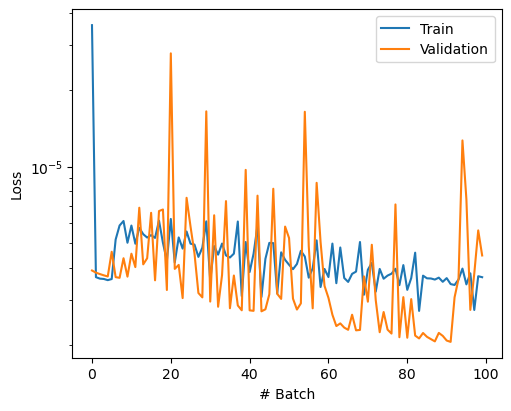

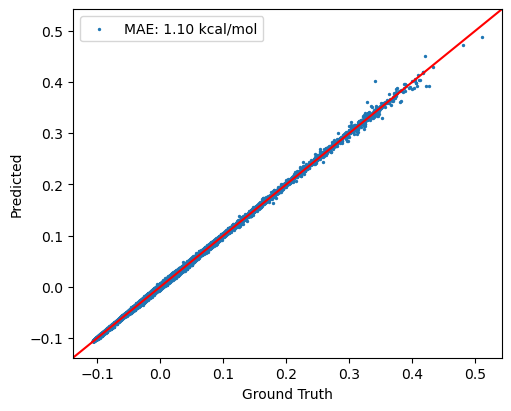

In [19]:
# Train the model using the train_data_loader and val_data_loader
deep_train_loss_list, deep_val_loss_list = deep_trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
deep_trainer.evaluate(test_data, draw_plot=True)

4.027321453892125e-06

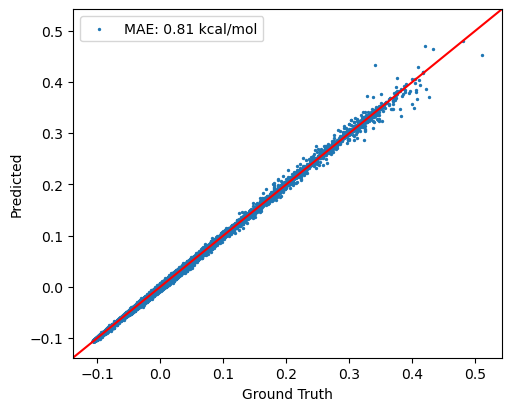

In [16]:
deep_trainer.evaluate(test_data, draw_plot=True)

In [18]:
# Instantiate the ANITrainer with the model, batch_size, epoch, and other necessary parameters
epoch = 100
batch_size = 4096
deep_trainer = ANITrainer(model=deep_model, batch_size=batch_size, epoch=epoch, opt_method="adam", loss_func=nn.MSELoss(), learning_rate=1e-4, l2=1e-7)

Sequential - Number of parameters: 329732


In [49]:
# Instantiate the ANITrainer with the model, batch_size, epoch, and other necessary parameters
epoch = 100
batch_size = 2048
wide_trainer = ANITrainer(model=wide_model, batch_size=batch_size, epoch=epoch, opt_method="adam", loss_func=nn.MSELoss(), learning_rate=1e-3, l2=1e-9)

Sequential - Number of parameters: 308804


Initialize training data...


100%|██████████| 100/100 [18:40<00:00, 11.20s/it]


1.9641961171519035e-06

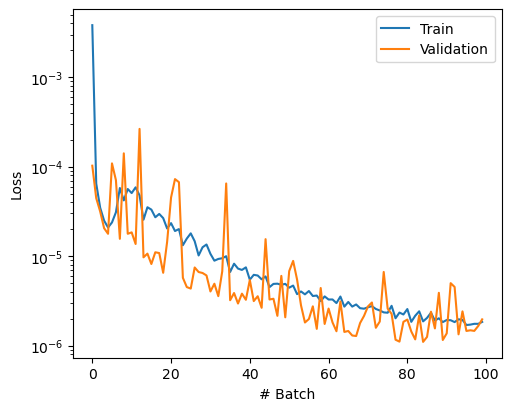

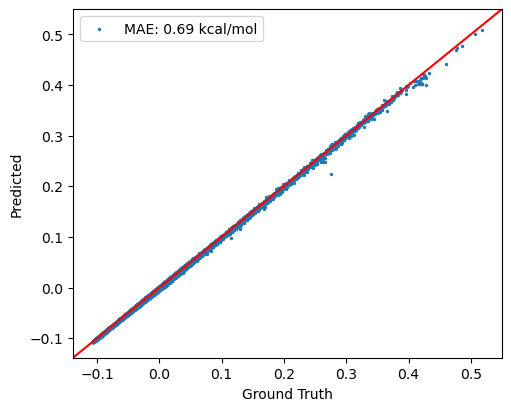

In [50]:
# Train the model using the train_data_loader and val_data_loader
train_loss_list, val_loss_list = wide_trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
wide_trainer.evaluate(test_data, draw_plot=True)

In [10]:
# Instantiate the ANITrainer with the model, batch_size, epoch, and other necessary parameters
epoch = 100
batch_size = 2048
atomic_trainer = ANITrainer(model=atomic_model, batch_size=batch_size, epoch=epoch, opt_method="adam", loss_func=nn.MSELoss(), learning_rate=1e-3, l2=1e-7)

Sequential - Number of parameters: 197636


Initialize training data...


100%|██████████| 100/100 [17:25<00:00, 10.46s/it]


2.1269636793563084e-06

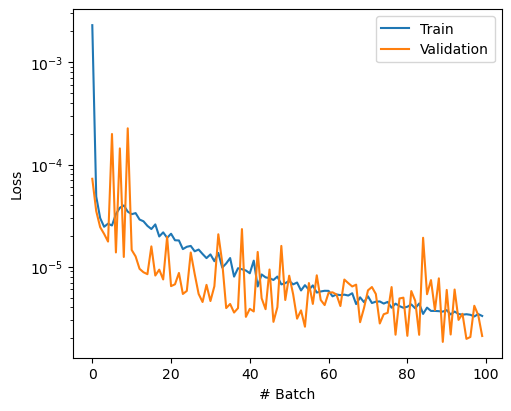

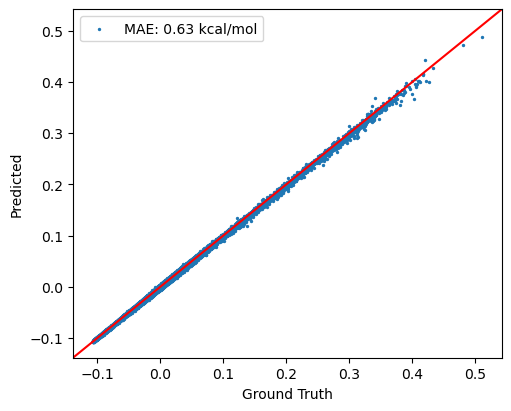

In [11]:
# Train the model using the train_data_loader and val_data_loader
atomic_train_loss_list, atomic_val_loss_list = atomic_trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
atomic_trainer.evaluate(test_data, draw_plot=True)

Initialize training data...


100%|██████████| 100/100 [20:15<00:00, 12.15s/it]


1.0547970598648817e-06

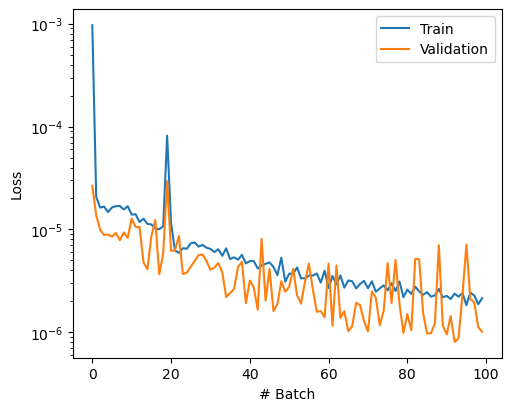

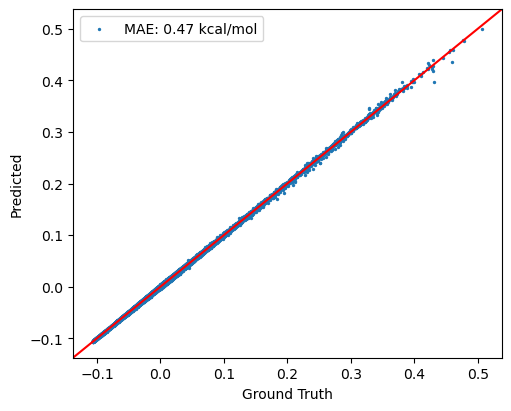

In [18]:
# Train the model using the train_data_loader and val_data_loader
train_loss_list, val_loss_list = trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
trainer.evaluate(test_data, draw_plot=True)

2.8398482470838087e-05

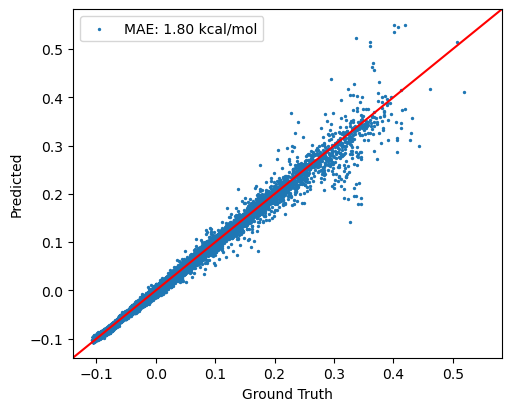

In [920]:
trainer.evaluate(test_data, draw_plot=True)